<a href="https://colab.research.google.com/github/Crisqin/Thesis/blob/main/thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import time
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets, models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.optim as optim


# Train and Valid function


In [17]:
# define train function
def train_and_valid(model, loss_function, optimizer, epochs=30):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device('cpu')
    history = []
    best_acc = 0.0
    best_epoch = 0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch + 1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = loss_function(outputs, labels)

            loss.backward()

            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()

            for j, (inputs, labels) in enumerate(valid_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                loss = loss_function(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                valid_acc += acc.item() * inputs.size(0)

        #avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size

        #avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size
        # Record the loss value and accuracy for each round
        history.append([train_loss, valid_loss, avg_train_acc, avg_valid_acc])
        ################learning rate update
        #scheduler.step()
        ################

        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(),'params.ckpt')
        epoch_end = time.time()
        # Print loss values and accuracies for each round, with the best validation set accuracy
        print(
            "Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}h".format(
                epoch + 1, valid_loss, avg_train_acc * 100, valid_loss, avg_valid_acc * 100,
                (epoch_end - epoch_start)/3600
            ))
        print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))

    return history


# Read image

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

image_path = "/content/drive/My Drive/DataSet/OLSFED/"   #2813 487 899

Mounted at /content/drive


# calculate mean and std


In [4]:
# def getStat(train_data):
#     '''
#     Compute mean and variance for training data
#     :param train_data: 自定义类Dataset(或ImageFolder即可)
#     :return: (mean, std)
#     '''
#     print('Compute mean and variance for training data.')
#     print(len(train_data))
#     train_loader = torch.utils.data.DataLoader(
#         train_data, batch_size=1, shuffle=False, num_workers=0,
#         pin_memory=True)
#     mean = torch.zeros(3)
#     std = torch.zeros(3)
#     for X, _ in train_loader:
#         for d in range(3):
#             mean[d] += X[:, d, :, :].mean()
#             std[d] += X[:, d, :, :].std()
#     mean.div_(len(train_data))
#     std.div_(len(train_data))
#     return list(mean.numpy()), list(std.numpy())

In [5]:
#train_dataset = datasets.ImageFolder(root=image_path + "train",transform=transforms.ToTensor())
#print(getStat(train_dataset))#([0.6008751, 0.5929872, 0.5754039], [0.2608221, 0.27570045, 0.27727532])

In [6]:
#valid_dataset = datasets.ImageFolder(root=image_path + "valid",transform=transforms.ToTensor())
#print(getStat(valid_dataset)) #[0.6006296, 0.59292805, 0.57553303], [0.26102078, 0.2756743, 0.27714193]
#test_dataset = datasets.ImageFolder(root=image_path + "test",transform=transforms.ToTensor())
#print(getStat(test_dataset)) #[0.60033476, 0.59253544, 0.575138], [0.26081982, 0.27557337, 0.27721775]

# Train and valid dataloader

In [7]:
# set hyperparameters
BATCH_SIZE = 32
# set train set
data_transform = {
  "train": transforms.Compose([transforms.CenterCrop(256),
                               transforms.RandomHorizontalFlip(),
                               transforms.ColorJitter(brightness=0.5, contrast=0.5),
                               transforms.ToTensor(),
                               transforms.Normalize([0.6009, 0.5930, 0.5754], [0.2608, 0.2757, 0.2773])
                  ]),
  "val": transforms.Compose([transforms.CenterCrop(256),
                             transforms.ToTensor(),
                             transforms.Normalize([0.6009, 0.5930, 0.5754], [0.2608, 0.2757, 0.2773])
            ])}


train_dataset = datasets.ImageFolder(root=image_path + "train",transform=data_transform["train"])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)  # load trian data

valid_dataset = datasets.ImageFolder(root=image_path + "test",transform=data_transform["val"])
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)  # load valid data

# pritn set size
train_data_size = len(train_dataset)
valid_data_size = len(valid_dataset)

print(train_data_size,valid_data_size)

15558 9342


# Train

In [9]:
#net = ResNet34().to("cuda") 
net = models.resnet101().to('cuda')
loss_function = nn.CrossEntropyLoss() 
optimizer = optim.Adam(net.parameters(), lr=0.005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs=8

In [10]:
start_time = time.time()
# strat training
history = train_and_valid(net, loss_function, optimizer, num_epochs)
PATH='/content/drive/My Drive/DataSet/trained model/resnet101_parameter.pkl'
torch.save(net.state_dict(),PATH)
print('Cost:',(time.time()-start_time)/3600)

Epoch: 1/8
Epoch: 001, Training: Loss: 59.8108, Accuracy: 99.7943%, 
		Validation: Loss: 59.8108, Accuracy: 18.5185%, Time: 5.2060h
Best Accuracy for validation : 0.1852 at epoch 001
Epoch: 2/8
Epoch: 002, Training: Loss: 63.5099, Accuracy: 100.0000%, 
		Validation: Loss: 63.5099, Accuracy: 18.5185%, Time: 0.1501h
Best Accuracy for validation : 0.1852 at epoch 001
Epoch: 3/8
Epoch: 003, Training: Loss: 64.7287, Accuracy: 100.0000%, 
		Validation: Loss: 64.7287, Accuracy: 18.5185%, Time: 0.1503h
Best Accuracy for validation : 0.1852 at epoch 001
Epoch: 4/8
Epoch: 004, Training: Loss: 62.6694, Accuracy: 100.0000%, 
		Validation: Loss: 62.6694, Accuracy: 18.5185%, Time: 0.1501h
Best Accuracy for validation : 0.1852 at epoch 001
Epoch: 5/8
Epoch: 005, Training: Loss: 67.0080, Accuracy: 100.0000%, 
		Validation: Loss: 67.0080, Accuracy: 18.5185%, Time: 0.1498h
Best Accuracy for validation : 0.1852 at epoch 001
Epoch: 6/8
Epoch: 006, Training: Loss: 65.9975, Accuracy: 100.0000%, 
		Validatio

In [16]:
history


[[0.017101243622950506,
  59.81078074836445,
  0.9979431803573724,
  0.18518518518518517],
 [0.0, 63.50986775043204, 1.0, 0.18518518518518517],
 [0.0, 64.72870744767675, 1.0, 0.18518518518518517],
 [0.0, 62.66937098240756, 1.0, 0.18518518518518517],
 [0.0, 67.00801527431246, 1.0, 0.18518518518518517],
 [0.0, 65.99754254931787, 1.0, 0.18518518518518517],
 [0.0, 65.61278804582234, 1.0, 0.18518518518518517],
 [0.0, 65.84329365407902, 1.0, 0.18518518518518517]]

# Plot accuracy and loss

In [11]:
def plot_acc_loss(history):
  # plot loss and accuracy figure
  history = np.array(history)
  plt.plot(history[:, 0:2])
  plt.legend(['Train Loss', 'Val Loss'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss')
  #plt.ylim(0, 1.1)
  plt.savefig('loss_curve.png')
  plt.show()

  plt.plot(history[:, 2:4])
  plt.legend(['Train Accuracy', 'Val Accuracy'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Accuracy')
  #plt.ylim(0, 1.1)
  plt.savefig('accuracy_curve.png')
  plt.show()

# Plot ResNet accuracy and loss

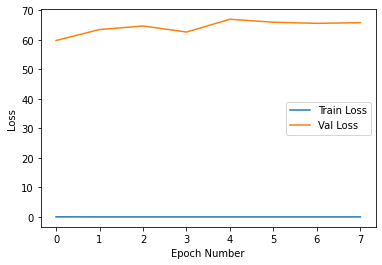

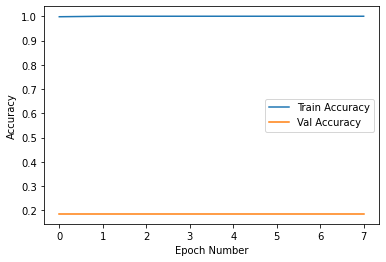

In [12]:
plot_acc_loss(history)

# Test

In [ ]:
test_transform = transforms.Compose([
        transforms.Resize((256, 256)),  # resize到224x224大小
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.6003, 0.5925, 0.5751], std=[0.2608, 0.2756, 0.2772]) 
    ])
test_dataset = datasets.ImageFolder(root=image_path + "test",transform=test_transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=2)  # load test data
test_data_size = len(test_dataset)
print(test_data_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for j, (inputs, labels) in enumerate(test_loader):
  inputs = inputs.to(device)
  labels = labels.to(device)

  outputs = model(inputs)

  loss = loss_function(outputs, labels)

  test_loss += loss.item() * inputs.size(0)

  ret, predictions = torch.max(outputs.data, 1)
  correct_counts = predictions.eq(labels.data.view_as(predictions))

  acc = torch.mean(correct_counts.type(torch.FloatTensor))

  test_acc += acc.item() * inputs.size(0)

avg_test_loss = test_loss / test_data_size
avg_test_acc = test_acc / test_data_size

print("Test: Loss: {:.4f}, Accuracy: {:.4f}%".format(avg_test_loss,avg_test_acc * 100))

# Pre train model

In [ ]:
pretrained_resnet101 = models.resnet101(pretrained=False)
PATH= '/content/drive/My Drive/DataSet/trained model/fer2013_resnet101_parameter.pkl'
pretrained_resnet101.load_state_dict(torch.load(PATH))
inchannel = pretrained_resnet101.fc.in_features
pretrained_resnet101.fc = nn.Linear(inchannel, 5)
pretrained_resnet101.to('cuda')

In [22]:
loss_function = nn.CrossEntropyLoss() 
optimizer = optim.Adam(pretrained_resnet101.parameters(), lr=0.01)
num_epochs = 8

In [ ]:
start_time = time.time()

# strat training
history_pretrained_resnet101 = train_and_valid(pretrained_resnet101, loss_function, optimizer, num_epochs)
PATH='/content/drive/My Drive/DataSet/trained model/pretrained_resnet101_parameter.pkl'
torch.save(net.state_dict(),PATH)
print('Cost:',(time.time()-start_time)/3600)

Epoch: 1/8
Epoch: 001, Training: Loss: 1198680.9075, Accuracy: 99.9550%, 
		Validation: Loss: 1198680.9075, Accuracy: 18.5185%, Time: 0.1489h
Best Accuracy for validation : 0.1852 at epoch 001
Epoch: 2/8
Epoch: 002, Training: Loss: 1247172.6034, Accuracy: 100.0000%, 
		Validation: Loss: 1247172.6034, Accuracy: 18.5185%, Time: 0.1488h
Best Accuracy for validation : 0.1852 at epoch 001
Epoch: 3/8
Epoch: 003, Training: Loss: 1206070.9761, Accuracy: 100.0000%, 
		Validation: Loss: 1206070.9761, Accuracy: 18.5185%, Time: 0.1488h
Best Accuracy for validation : 0.1852 at epoch 001
Epoch: 4/8
Epoch: 004, Training: Loss: 1219338.0028, Accuracy: 100.0000%, 
		Validation: Loss: 1219338.0028, Accuracy: 18.5185%, Time: 0.1489h
Best Accuracy for validation : 0.1852 at epoch 001
Epoch: 5/8
Epoch: 005, Training: Loss: 1237071.2604, Accuracy: 100.0000%, 
		Validation: Loss: 1237071.2604, Accuracy: 18.5185%, Time: 0.1487h
Best Accuracy for validation : 0.1852 at epoch 001
Epoch: 6/8
Epoch: 006, Training

In [ ]:
plot_acc_loss(history_pretrained_resnet34)